In [166]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from itertools import permutations
import random
import math
from tqdm.auto import tqdm
import copy

In [167]:
class Node:
    def __init__(self, depth, index, parent=None) -> None:
        self.depth = depth
        self.index = index
        self.parent = parent
        self.left = None
        self.right = None
        self.active = False
        self.mean_estimates = []
        self.proba = 0.0
        self.size = 1/(2**(self.depth-1))

    def __eq__(self, other: object) -> bool:
        return self.depth == other.depth and self.index == other.index
    
    def __hash__(self) -> int:
        return hash((self.depth, self.index))
    
    def subdivide(self):
        self.left = Node(self.depth + 1, 2 * self.index - 1, parent=self)
        self.right = Node(self.depth + 1, 2 * self.index, parent=self)

    def evict(self):
        self.active = False
        if self.left :
            self.left.evict()
        if self.right:
            self.right.evict()

    def contains(self, x):
        left = (self.index-1) / (2**(self.depth-1))
        right = (self.index) / (2 ** (self.depth-1))
        return left <= x <= right
    
    def get_parent(self, target_depth):
        """ 
        Enumerate the list of children of a given node
        """
        if target_depth >= self.depth :
            return None
        current = self
        while current and current.depth > target_depth:
            current = current.parent
        return current

    def get_descendants_at_depth(self, target_depth):
        if target_depth <= self.depth :
            return []
        result = []

        def helper(node):
            if node is None :
                return
            if node.depth == target_depth :
                result.append(node)
            elif node.depth < target_depth :
                helper(node.left)
                helper(node.right)
        helper(self)
        return result
    
    def get_active_children(self, target_depth):
        if target_depth <= self.depth :
            return []
        
        result = []

        def dfs(node):
            if node is None :
                return
            if node.depth == target_depth and node.active :
                result.append(node)
            elif node.depth < target_depth :
                dfs(node.left)
                dfs(node.right)
                
        dfs(self)
        return result
    
    def sample(self):
        """ Sample one action (i.e. number) in node """
        left = (self.index-1) / (2**(self.depth-1))
        right = (self.index) / (2 ** (self.depth-1))
        return random.uniform(left, right)


    def __repr__(self) -> str:
        return f"({self.depth},{self.index})"

In [168]:
class Tree:

    def __init__(self, max_depth) -> None:
        self.max_depth = max_depth
        self.root = Node(1, 1)
        
        if max_depth is not None:
            self.build_full_tree(node=self.root, max_depth=max_depth)

        self.initialize_active_depth() 

    def build_full_tree(self, node, max_depth):
        """ Build tree of size max_depth recursively with node as root"""
        if node.depth >= max_depth:
            return
        node.subdivide()
        self.build_full_tree(node.left, max_depth)
        self.build_full_tree(node.right, max_depth)

    def initialize_active_depth(self):
        self.active_depths = {}
        active_nodes = self.collect_active_nodes(self.max_depth)
        self.active_depths[self.max_depth] = active_nodes
        self.activate_depth(self.max_depth)
        

    def activate_depth(self, depth):
        """ 
        Make depth active, i.e. activate all its nodes and add this depth to the set of active depths
        Note that activating one node also actives all its children
        """
        
        # Activate nodes
        def activate_at_depth(node):
            if node is None :
                return
            if node.depth == depth :
                node.active = True
                #activate_children(node.left)
                #activate_children(node.right)
                
            elif node.depth < depth :
                activate_at_depth(node.left)
                activate_at_depth(node.right)

        activate_at_depth(self.root)
        nodes = self.collect_active_nodes(depth)
        self.active_depths[depth] = nodes
        self.update_proba() # en vrai jpense a chaque fois qu'on active un depth faut re-update les pb
    
    def de_activate_depth(self, depth):
        """ 
        Make depth not active, i.e. de-activate all its nodes and add this depth to the set of active depths
        """
        
        # Activate nodes
        def de_activate_at_depth(node):
            if node is None :
                return
            if node.depth == depth :
                node.active = False
                
            elif node.depth < depth :
                de_activate_at_depth(node.left)
                de_activate_at_depth(node.right)

        de_activate_at_depth(self.root)
        del self.active_depths[depth]
        self.update_proba() # en vrai jpense a chaque fois qu'on active un depth faut re-update les pb
        

    def find_node(self, depth, index):
        node = self.root
        for d in range(1, depth):
            if node is None :
                return None
            bit = ((index - 1) >> (depth - d - 1)) & 1
            node = node.right if bit else node.left
        return node if node and node.depth == depth and node.index == index else None
        
    def collect_active_nodes(self, depth):
        def helper_collect_active_nodes(node, depth):
        # base
            if node is None:
                return []
            if node.depth == depth and node.active :
                return [node]
            return helper_collect_active_nodes(node.left, depth) + helper_collect_active_nodes(node.right, depth) 
    
        return helper_collect_active_nodes(self.root, depth)
    
    def update_proba(self):
        """
        Update each node's probability according to the hierarchical sampling scheme.
        Only active nodes at active depths can receive nonzero probabilities.
        """
        # Reset all probabilities to 0
        def reset_probs(node):
            if node is None:
                return
            node.proba = 0.0
            reset_probs(node.left)
            reset_probs(node.right)

        reset_probs(self.root)

        if not self.active_depths:
            return

        active_depths = sorted(self.active_depths.keys())
        min_depth = active_depths[0]
        min_depth_nodes = [n for n in self.active_depths[min_depth] if n.active]

        if not min_depth_nodes:
            return

        base_prob = 1.0 / len(min_depth_nodes)

        # Recursively assign probability only to active children at active depths
        def recurse(node, depth_idx, prob):
            if depth_idx >= len(active_depths):
                return

            current_depth = active_depths[depth_idx]

            if node.depth != current_depth or not node.active:
                return

            node.proba = prob

            # Recurse to next active depth
            if depth_idx + 1 >= len(active_depths):
                return

            next_depth = active_depths[depth_idx + 1]

            # Get all active children of `node` at the next active depth
            children_at_next = node.get_descendants_at_depth(next_depth)
            active_children = [child for child in children_at_next if child.active]

            if not active_children:
                return

            child_prob = prob / len(active_children)

            for child in active_children:
                recurse(child, depth_idx + 1, child_prob)

        for node in min_depth_nodes:
            recurse(node, 0, base_prob)

        
    def update_estimates(self, x_t, y_t):

        def update_node(node):
            if node is None:
                return      
            
            if not node.contains(x_t) or not node.active:
                node.mean_estimates.append(0.0)
            
            else :
                p = node.proba
                mean_estimate_t = (y_t/p) 
                node.mean_estimates.append(mean_estimate_t)
            

            update_node(node.left)
            update_node(node.right)
            
        update_node(self.root)

    def set_to_list(self, list_nodes):
        for node in list_nodes :
            current_node = self.find_node(node.depth, node.index)
            current_node.__dict__.update(node.__dict__)

    def visualize(self, filename="dyadic_tree"):
            
            dot = Digraph()

            def add_nodes_edges(node):
                if node is None:
                    return
                # Color node based on activity
                color = "green" if node.active else "red"
                label = f"p={np.round(node.proba, 3)}, {np.round(np.mean(node.mean_estimates), 3) if node.mean_estimates != [] else 0.0}"
                dot.node(name=str(id(node)), label=label, style="filled", fillcolor=color)

                for child in [node.left, node.right]:
                    if child:
                        dot.edge(str(id(node)), str(id(child)))
                        add_nodes_edges(child)

            add_nodes_edges(self.root)
            dot.render(filename, format="png", cleanup=True)
            print(f"Tree image saved as {filename}.png")

In [169]:
class MBDE :
    def __init__(self, T) -> None:
        self.T = T
        self.t = 1
        self.l = 0 # current episode

        # Constants
        self.c0 = 0.56 

    def initialize_episode(self):
        self.l+=1
        print(f'Entering Episode {self.l}')
        self.block = 0
        self.m = 2 # bon ca fait pas trop sens de considerer qu'une seule bin, on perd des rounds inutilement

    def initialize_block(self):
        
        self.m+=1
        print(f'Entering block {self.m}')
        self.ScheduleReplays()
        #self.tree.active_depths = self.active_depth_set() en fait on initialize direct a m au 1er round
        
        self.starting_block = copy.deepcopy(self.t)
        self.ending_block = self.starting_block + 8**self.m

        self.tree = Tree(self.m)
        self.d_t = {self.m}
        self.tree.update_proba()

        self.B_MASTER = copy.deepcopy(self.tree.active_depths[self.m])

    def ScheduleReplays(self):
        """ Schedule all replays for a given block of size 8^m, depths >= 2 """
        self.Replays = np.zeros((8**self.m, self.m - 2))  # depths from 2 to m-1 => m-2 columns

        for s in range(8**self.m):  # 0-based indexing
            for d in range(2, self.m):  # depth d ∈ [2, m-1]
                if s % 8**d == 0:
                    p_s_d = np.sqrt(8**d / (s + 1))  # s+1 because s is 0-indexed now
                    R_s_d = int(np.random.random() < p_s_d)
                    self.Replays[s, d - 2] = R_s_d  # d-2 maps depth 2 → column 0, etc.

        self.get_mask()
        self.visualize_replays()


    def get_mask(self):
        self.active_mask = np.zeros_like(self.Replays)

        for d_index in reversed(range(self.m - 2)):  # corresponds to depths from 2 to m-1
            d = d_index + 2
            length = 8**d
            for s in range(8**self.m):
                if self.Replays[s, d_index] == 1:
                    end = min(s + length, 8**self.m)
                    for t in range(s, end):
                        if not self.active_mask[t].any():  # only assign if no deeper depth active
                            self.active_mask[t, d_index] = 1



    def active_depth_set(self):
        """ 
        gives the set of active depths at current round
        """
        if self.t < 0 or self.t >= self.active_mask.shape[0]:
            raise ValueError('Round s is out of bounds')
        return {self.m}.union({d for d, active in enumerate(self.active_mask[self.t]) if active == 1})
    
    def check_if_replay(self):

        # Check if new replay begins
        old_set = set(self.tree.active_depths.keys())
        new_set = self.active_depth_set()
        new_depths = new_set - old_set
        removed_depths = old_set - new_set

        # la je fais dans le setting ou il n'y a que 1 seul replay à la fois
        
        if new_depths : # si on entre dans un replay
            for d in new_depths:
                print(f'We activate depth {d} at time {self.t}')
                self.tree.activate_depth(d)
            self.tree.activate_depth(self.m) # on active le depth le + profond

                # Do something
                # ...
                # Je me rappelle plus si il faut reactiver toutes les bins ou juste celles à cette depth ?
        
        if removed_depths : # si on sort d'un replay
            for d in removed_depths:
                print(f'We remove depth {d} at time {self.t}')
                self.tree.de_activate_depth(d)

            # now cB_t(m) = B_MASTER
            for node in self.B_MASTER:
                self.tree.active_depths[self.m] = list(set(self.tree.active_depths[self.m]) & set(self.B_MASTER))
                #self.tree.node.active = True
                # Do something
                # ...


    def choose_action(self) :

        self.check_if_replay()

        min_depth = min(self.tree.active_depths)
        candidates = self.tree.active_depths[min_depth]
        probs = [node.proba for node in candidates]
        current = random.choices(candidates, weights=probs, k=1)[0]

        for depth in sorted(self.tree.active_depths) :
            if depth <= current.depth :
                continue

            children = [
                node for node in self.tree.active_depths[depth] 
                if node.active and node.parent == current
                ] # bon la ptet pas optimal
            
            if not children :
                break
            current = random.choice(children)
        x_t = current.sample()
        
        return x_t
    

    def update(self, x_t, y_t):
        self.tree.update_estimates(x_t, y_t)
        #if self.t >= 2 :
        self.eviction_test()
        self.tree.update_proba()
        self.t+=1
        self.B_MASTER = list(set(self.tree.active_depths[self.m]) & set(self.B_MASTER))
        self.check()

    def eviction_test(self):
        flag = False
        def treshhold(s1, s2, d):
            return self.c0 * math.log(self.T) * math.sqrt( (s2 - s1)*(2**d) ) + (4 * (s2 - s1) /2**d)
        
        def eviction_criteria(B1, B2, d) :
            """ Check if cumulative diff between B_1 and B_2 triggers positive test  """
            n = self.t - self.starting_block
            diff = [B1.mean_estimates[i] - B2.mean_estimates[i] for i in range(n)]
            #for s1 in range(n-1):
            #    cumsum = 0
            #    for s2 in range(s1+1, n):
            #        cumsum+= diff[s2]
            #        if cumsum > treshhold(s1, s2, d):
            #            print('true')
            #            return True

            cumsum = 0
            s1 = 1
            for s2 in range(s1+1, n):
                cumsum+= diff[s2]
                if cumsum > treshhold(s1, s2, d):
                    print('true')
                    return True

                    
        for d, active_nodes_d in self.tree.active_depths.items() :
            for B, B_prim in permutations(active_nodes_d, 2):
                if eviction_criteria(B, B_prim, d): 
                    print(f'{B_prim.index} evicted')
                    # then evict B
                    B_prim.evict()
                    flag = True
                    continue
        if flag :
            for d in self.tree.active_depths :
                active_nodes_d = self.tree.collect_active_nodes(d)
                self.tree.active_depths[d] = active_nodes_d


    def check(self):
        
        # If block ends because there is a shift
        if len(self.B_MASTER) == 0:
            print(f'Shift at {self.t}')
            self.initialize_episode()
            self.initialize_block()
            
        # If block ends naturally
        if self.t == self.ending_block : # if block ends naturally
            print(self.t)
            self.initialize_block()

    def visualize_replays(self):
        """
        Visualizes the active mask with active intervals and markers at actual replay start times.
        """
        m = self.active_mask.shape[1] + 2  # total number of depths including offset (depths 2 to m-1)
        T = self.active_mask.shape[0]
        
        plt.figure(figsize=(12, (m - 2) * 0.6))
        plt.imshow(self.active_mask.T, aspect='auto', cmap='YlOrBr', interpolation='nearest')
        plt.ylabel("Depth")
        plt.xlabel("Time")
        plt.title("Active Intervals Over Time by Depth")
        plt.yticks(
            ticks=range(m - 2),
            labels=[f"Depth {d}" for d in range(2, m)]
        )

        # Add red markers exactly where replays are triggered (from self.Replays)
        for d_index in range(m - 2):  # depth d = d_index + 2
            for t in range(T):
                if self.Replays[t, d_index] == 1:
                    plt.plot(t, d_index, marker='o', color='red', markersize=4)

        plt.tight_layout()
        plt.show()


In [170]:
class Environment :
    def __init__(self, T, nb_shifts) -> None:
        self.T = T
        self.nb_shifts = nb_shifts

    def mean_reward(self, t):
        # Nave test, just for sanity check for now
        def naive_function(x):
            width = 0.3
            center = 0.5
            distance = abs(x - center)
            if distance < width:
                return 1 - distance / width
            else:
                return 0.0
        return naive_function
    
    def get_reward(self, t, x):
        return self.mean_reward(t)(x)

In [171]:
class Simulator :
    def __init__(self, algo, env, T) -> None:
        self.algo = algo
        self.env = env
        self.T = T
    
    def run(self):
        for t in tqdm(range(self.T)) :
            x_t = self.algo.choose_action()
            y_t = self.env.get_reward(t, x_t)
            self.algo.update(x_t, y_t)

Entering Episode 1
Entering block 3


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_3517/601676632.py:214: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


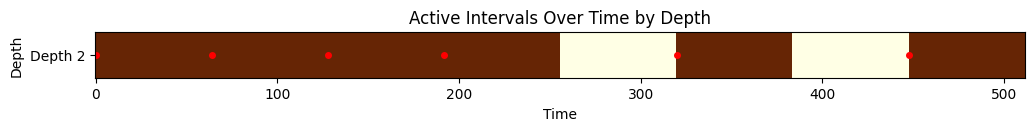

In [172]:
T = 1000
env = Environment(T, 3)
algo = MBDE(T)

algo.initialize_episode()
algo.initialize_block()
#algo.tree.activate_depth(2) # TODO: change
#algo.tree.update_proba()
#algo.tree.visualize_tree()

In [174]:
algo.tree.visualize()

Tree image saved as dyadic_tree.png


In [175]:
sim = Simulator(algo, env, T)
sim.run()

  0%|          | 0/1000 [00:00<?, ?it/s]

We activate depth 0 at time 1


IndexError: list index out of range

In [176]:
sim.algo.tree.active_depths

{3: [(3,1), (3,2), (3,3), (3,4)], 0: []}

In [71]:
sim.algo.tree.visualize()

Tree image saved as dyadic_tree.png


In [28]:
len(sim.algo.tree.find_node(2, 1).mean_estimates)

33

In [ ]:
[sim.algo.tree.find_node(2, 1).mean_estimates[i] - sim.algo.tree.find_node(2, 2).mean_estimates[i] for i in range(n)]

In [61]:
sim.algo.tree.find_node(2, 2).mean_estimates

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [36]:
algo.tree.find_node(2, 1).evict()
for d in algo.tree.active_depths :
    active_nodes_d = algo.tree.collect_active_nodes(d)
    algo.tree.active_depths[d] = active_nodes_d

algo.tree.update_proba()
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [38]:
list(set(algo.tree.active_depths[algo.m]) & set(algo.B_MASTER))

[(5,15), (5,11), (5,14), (5,13), (5,10), (5,16), (5,9), (5,12)]

In [37]:
for element in list(set(algo.B_MASTER)) :
    if element in list(set(algo.tree.active_depths[algo.m])) :
        print('comon')

comon
comon
comon
comon
comon
comon
comon
comon


In [22]:
list(set(algo.B_MASTER))

[(5,4),
 (5,15),
 (5,7),
 (5,14),
 (5,9),
 (5,11),
 (5,8),
 (5,2),
 (5,5),
 (5,16),
 (5,12),
 (5,3),
 (5,10),
 (5,1),
 (5,13),
 (5,6)]

L'intersecton a un bug, je capte pas

[]

In [35]:
set(algo.tree.active_depths[algo.m])

{(5,10), (5,11), (5,12), (5,13), (5,14), (5,15), (5,16), (5,9)}

In [36]:
set.intersection(set(algo.B_MASTER) , set(algo.tree.active_depths[algo.m]))

set()

In [23]:
algo.B_MASTER = list(set(algo.tree.active_depths[algo.m]) & set(algo.B_MASTER))

In [24]:
algo.B_MASTER 

[]

In [8]:
algo.tree.set_to_list(algo.B_MASTER)
algo.tree.update_proba()

In [9]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [50]:
for node in algo.B_MASTER:
    print(node.active)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [17]:
for node in algo.B_MASTER :
    print(node.active)

AttributeError: 'MBDE' object has no attribute 'B_MASTER'

In [35]:
for node in algo.B_MASTER :
    print(node.active)

False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True


In [30]:
algo.tree.set_to_list(algo.B_MASTER)
algo.tree.visualize_tree()


Tree image saved as dyadic_tree.png


In [31]:
for node in algo.B_MASTER :
    #current_node.__dict__.update(node.__dict__)
    algo.tree.find_node(node.depth, node.index).active = node.active

In [32]:
algo.tree.find_node(5, 1).active

False

In [14]:
algo.tree.find_node(5, 1).__dict__

{'depth': 5,
 'index': 1,
 'parent': (4,1),
 'left': None,
 'right': None,
 'active': False,
 'mean_estimates': [],
 'proba': 0.0,
 'size': 0.0625}

In [80]:
algo.tree.active_depths[algo.m] = algo.B_MASTER

In [81]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [38]:
t1 = algo.tree.collect_active_nodes(5)

In [39]:
t2 = [algo.tree.find_node(5, 2),algo.tree.find_node(5, 5)]

In [41]:
t1

[(5,5),
 (5,6),
 (5,7),
 (5,8),
 (5,9),
 (5,10),
 (5,11),
 (5,12),
 (5,13),
 (5,14),
 (5,15),
 (5,16)]

In [47]:
t3 = t1.copy()
for node in t3 :
    print(node.proba)

0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625


In [48]:
algo.tree.active_depths[algo.m]

[(5,1),
 (5,2),
 (5,3),
 (5,4),
 (5,5),
 (5,6),
 (5,7),
 (5,8),
 (5,9),
 (5,10),
 (5,11),
 (5,12),
 (5,13),
 (5,14),
 (5,15),
 (5,16)]

In [40]:
t2

[(5,2), (5,5)]

In [43]:
set(t1) & set(t2)

{(5,5)}

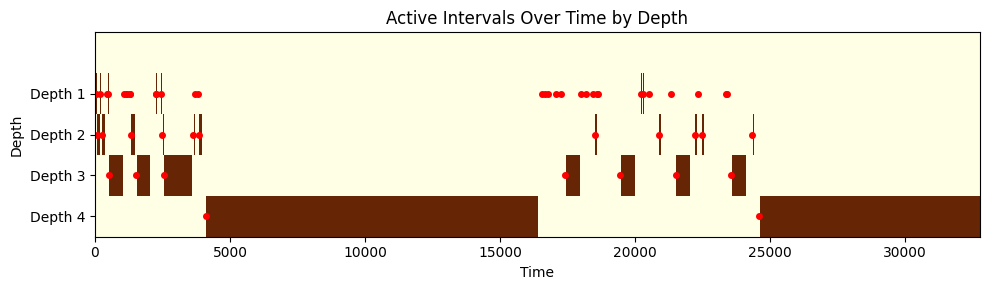

In [15]:
algo.plot_active_mask()

In [8]:
old_set = set(algo.tree.active_depths.keys())
new_set = {2, 5}
new_depths = new_set - old_set
removed_depths = old_set - new_set


In [9]:
if new_depths :
    for d in new_depths:
        algo.tree.activate_depth(d)
        
if removed_depths :
    for d in removed_depths:
        algo.tree.de_activate_depth(d)
        # Do something
        # ...

algo.tree.visualize_tree()


Tree image saved as dyadic_tree.png


In [10]:
algo.tree.find_node(3, 1).active

False

In [ ]:


                # Do something
                # ...

In [11]:
sim = Simulator(algo, env, T)

sim.run()


  0%|          | 0/600 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'set' and 'dict'

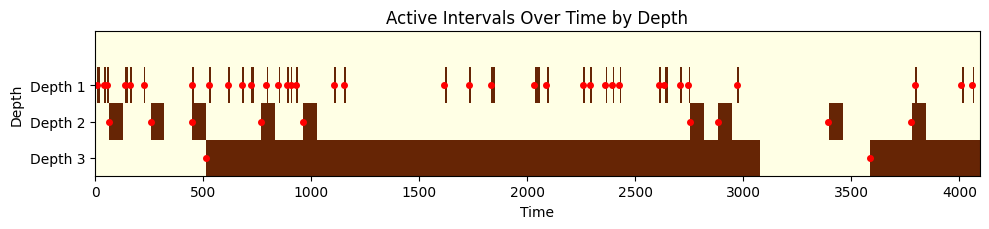

In [369]:
sim.algo.get_active_depths()
sim.algo.plot_active_mask()

In [356]:
sim.algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [346]:
algo.ending_block

4673

In [347]:
algo.t

600

In [348]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [320]:
algo.t

150

In [305]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [153]:
2**5

32

In [115]:
len(algo.tree.find_node(7, 1).mean_estimates)

499

In [117]:
diff = [algo.tree.find_node(7, 32).mean_estimates[i] - algo.tree.find_node(7, 1).mean_estimates[i] for i in range(400)]
np.cumsum(diff)


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41104316,
        61.41104316,  61.41104316,  61.41104316,  61.41

In [121]:
def treshhold(s1, s2, d):
    return 1 * math.log(200) * math.sqrt( (s2 - s1)*(2**d) ) + (4 * (s2 - s1) /2**d)
res_temp = []
for s_2 in range(2, 5000):
    res_temp.append(treshhold(1,s_2,7))

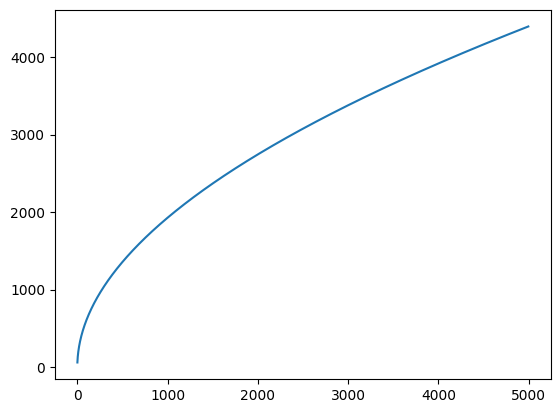

In [122]:
plt.plot(res_temp)

In [280]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [151]:
algo = MBDE(100)
algo.initialize_episode()
algo.initialize_block()
algo.get_mask()
algo.t = 1400
algo.get_active_depths()

hello 262144


{6}

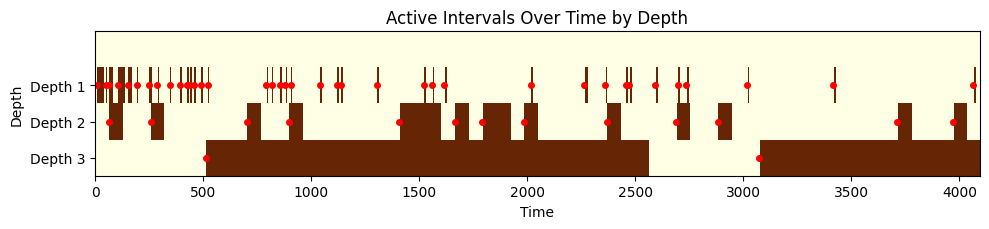

In [37]:
algo.plot_active_mask()

In [40]:
tree = Tree(4)
tree.update_proba()
tree.update_estimates(0.22, 0.60)
tree.visualize_tree()


0.0 1.0
Node(1, 1, False) contains
0.0 0.5
Node(2, 1, False) contains
0.0 0.25
Node(3, 1, False) contains
0.0 0.125
0.125 0.25
Node(4, 2, True) contains
coucou
0.125
0.25 0.5
0.25 0.375
0.375 0.5
0.5 1.0
0.5 0.75
0.5 0.625
0.625 0.75
0.75 1.0
0.75 0.875
0.875 1.0
Tree image saved as dyadic_tree.png


In [50]:
for d, active_nodes in tree.active_depths.items():
    print('d = ', d)
    print('active nodes = ', active_nodes)

d =  4
active nodes =  [Node(4, 1, True), Node(4, 2, True), Node(4, 3, True), Node(4, 4, True), Node(4, 5, True), Node(4, 6, True), Node(4, 7, True), Node(4, 8, True)]


In [181]:
def naive_function(x):
    width = 0.3
    center = 0.5
    distance = abs(x - center)
    if distance < width:
        return 1 - distance / width
    else:
        return 0.0

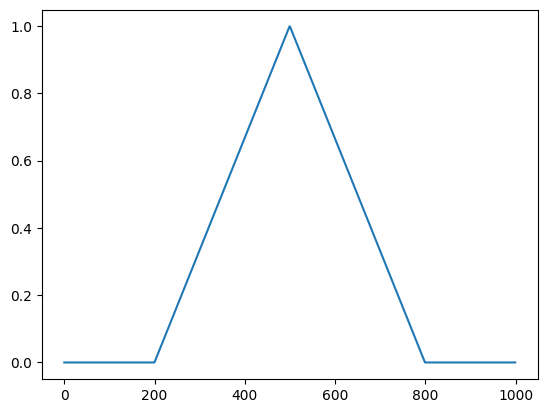

In [182]:
plt.plot([naive_function(x) for x in np.linspace(0, 1, 1000)])